# NIH-Faces: Facial Genetic Syndromes

## 1. Face detection and alignment

In [1]:
import pathlib, natsort
import numpy as np
import pandas as pd
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

In [2]:
# read image paths
data_root = '/media/omersumer/DATA/databases/NIH-Faces'
image_paths = natsort.natsorted(pathlib.Path(data_root, 'images').rglob('*.png'))

# initiate log file
log_file = open(pathlib.Path(pathlib.Path.cwd(), 'metadata', 'facedet.csv').as_posix(), 'w')

# Initialize face detector
ctx = 0         # ctx id, <0 means using cpu
det_size = 256  # detection size

app = FaceAnalysis()
app.prepare(ctx_id=ctx, det_size=(det_size, det_size))

# Run on all images
#print('image_name,bb_x1,bb_y1,bb_x2,bb_y2,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,score')
log_file.write('image_name,bb_x1,bb_y1,bb_x2,bb_y2,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,score\n')

for index in range(0, len(image_paths)):
    
    if index%500==0:
        print(index, len(image_paths))

    image_path = image_paths[index]
    img = cv2.imread(image_path.as_posix())
    faces = app.get(img)
    
    if faces is not None:
        if len(faces)==1:

            # read bbox and 5-points
            image_name = image_path.name
            bb_x1, bb_y1, bb_x2, bb_y2 = faces[0]['bbox']
            x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = faces[0]['kps'].reshape(-1)
            score = faces[0]['det_score']

            # print bbox and 5-point locations
            #print(image_name + ',' + ','.join(['%2.3f'%i for i in [bb_x1, bb_y1, bb_x2, bb_y2, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, score]]))
            log_file.write('%s\n'%(image_name + ',' + ','.join(['%2.3f'%i for i in [bb_x1, bb_y1, bb_x2, bb_y2, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, score]])))
            log_file.flush()

        elif len(faces)>1:

            for i in range(0, len(faces)):
                # read bbox and 5-points
                image_name = image_path.name
                bb_x1, bb_y1, bb_x2, bb_y2 = faces[i]['bbox']
                x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = faces[i]['kps'].reshape(-1)
                score = faces[i]['det_score']

                # print bbox and 5-point locations
                #print(image_name + ',' + ','.join(['%2.3f'%i for i in [bb_x1, bb_y1, bb_x2, bb_y2, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, score]]))
                log_file.write('%s\n'%(image_name + ',' + ','.join(['%2.3f'%i for i in [bb_x1, bb_y1, bb_x2, bb_y2, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, score]])))
                log_file.flush()
                
    else:
        image_name = image_path.name
        #print(image_name + ',' + ','.join([str(i) for i in [-1]*15]))
        log_file.write('%s\n'%(image_name + ',' + ','.join([str(i) for i in [-1]*15])))
        log_file.flush()
        
log_file.close()

/home/omersumer/miniconda3/envs/facial-genetics/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/omersumer/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/omersumer/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/omersumer/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/omersumer/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/omersumer/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112]

/home/omersumer/miniconda3/envs/facial-genetics/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


500 3547
1000 3547
1500 3547
2000 3547
2500 3547
3000 3547
3500 3547


## 2. Manually check images with more than one faces and delete 2nd person/false positives 
We have only one subject/face in an image. RetineFace mostly works and this manual inspection is needed for only a few images with more than one detection.

In [36]:
import pathlib, natsort
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#data_root = '/media/omersumer/DATA/databases/NIH-Faces'
#df = pd.read_csv(pathlib.Path(data_root, 'metadata', 'facedet.csv'))

df = pd.read_csv(pathlib.Path(pathlib.Path.cwd(), 'metadata', 'facedet.csv'))
print('==> ', df['image_name'].unique().shape, df.shape[0])
print([i for i in df['image_name'].unique() if sum(df['image_name'].to_numpy()==i)>1])

==>  (3547,) 3547
[]


[array(1914)]


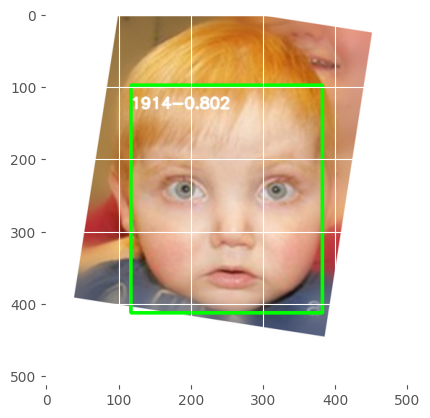

In [37]:
image_name = 'KSSlide86.png'
data_root = '/media/omersumer/DATA/databases/NIH-Faces'
image_path = pathlib.Path(data_root, 'images', image_name)
image = cv2.imread(image_path.as_posix())
indices = np.argwhere(df['image_name'].to_numpy()==image_name).squeeze()
indices = list(indices) if indices.size>1 else [indices]
print(indices)

for i in indices:
    bb_x1, bb_y1, bb_x2, bb_y2 = df.iloc[i]['bb_x1'], df.iloc[i]['bb_y1'], df.iloc[i]['bb_x2'], df.iloc[i]['bb_y2']
    score = df.iloc[i]['score']

    image = cv2.rectangle(image,(int(bb_x1), int(bb_y1)),(int(bb_x2), int(bb_y2)),(0,255,0),3)
    image = cv2.putText(image, str(i)+'-'+str(score), (int(bb_x1), int(bb_y1 + 0.1*(bb_y2-bb_y1))), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## 3. Visualize aligned image patches

In [38]:
import pathlib, natsort
import numpy as np
from skimage import transform as trans
import pandas as pd
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

arcface_dst = np.array(
    [[38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366],
     [41.5493, 92.3655], [70.7299, 92.2041]],
    dtype=np.float32)

def estimate_norm(lmk, image_size=112,mode='arcface'):
    assert lmk.shape == (5, 2)
    assert image_size%112==0 or image_size%128==0
    if image_size%112==0:
        ratio = float(image_size)/112.0
    else:
        ratio = float(image_size)/128.0
    dst = arcface_dst * ratio
    tform = trans.SimilarityTransform()
    tform.estimate(lmk, dst)
    M = tform.params[0:2, :]
    return M

def norm_crop(img, landmark, image_size=112, mode='arcface'):
    M = estimate_norm(landmark, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped

def norm_crop2(img, landmark, image_size=112, mode='arcface'):
    M = estimate_norm(landmark, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped, M

def square_crop(im, S):
    if im.shape[0] > im.shape[1]:
        height = S
        width = int(float(im.shape[1]) / im.shape[0] * S)
        scale = float(S) / im.shape[0]
    else:
        width = S
        height = int(float(im.shape[0]) / im.shape[1] * S)
        scale = float(S) / im.shape[1]
    resized_im = cv2.resize(im, (width, height))
    det_im = np.zeros((S, S, 3), dtype=np.uint8)
    det_im[:resized_im.shape[0], :resized_im.shape[1], :] = resized_im
    return det_im, scale


def transform(data, center, output_size, scale, rotation):
    scale_ratio = scale
    rot = float(rotation) * np.pi / 180.0
    #translation = (output_size/2-center[0]*scale_ratio, output_size/2-center[1]*scale_ratio)
    t1 = trans.SimilarityTransform(scale=scale_ratio)
    cx = center[0] * scale_ratio
    cy = center[1] * scale_ratio
    t2 = trans.SimilarityTransform(translation=(-1 * cx, -1 * cy))
    t3 = trans.SimilarityTransform(rotation=rot)
    t4 = trans.SimilarityTransform(translation=(output_size / 2,
                                                output_size / 2))
    t = t1 + t2 + t3 + t4
    M = t.params[0:2]
    cropped = cv2.warpAffine(data,
                             M, (output_size, output_size),
                             borderValue=0.0)
    return cropped, M


def trans_points2d(pts, M):
    new_pts = np.zeros(shape=pts.shape, dtype=np.float32)
    for i in range(pts.shape[0]):
        pt = pts[i]
        new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32)
        new_pt = np.dot(M, new_pt)
        #print('new_pt', new_pt.shape, new_pt)
        new_pts[i] = new_pt[0:2]

    return new_pts


def trans_points3d(pts, M):
    scale = np.sqrt(M[0][0] * M[0][0] + M[0][1] * M[0][1])
    #print(scale)
    new_pts = np.zeros(shape=pts.shape, dtype=np.float32)
    for i in range(pts.shape[0]):
        pt = pts[i]
        new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32)
        new_pt = np.dot(M, new_pt)
        #print('new_pt', new_pt.shape, new_pt)
        new_pts[i][0:2] = new_pt[0:2]
        new_pts[i][2] = pts[i][2] * scale

    return new_pts


def trans_points(pts, M):
    if pts.shape[1] == 2:
        return trans_points2d(pts, M)
    else:
        return trans_points3d(pts, M)


In [39]:
data_root = '/media/omersumer/DATA/databases/NIH-Faces'
df = pd.read_csv(pathlib.Path(pathlib.Path.cwd(), 'metadata', 'facedet.csv'))

df

,image_name,bb_x1,bb_y1,bb_x2,bb_y2,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,score
0,22q11DSSlide2.png,92.758,99.113,385.636,456.403,192.538,238.889,320.169,242.195,268.779,297.760,219.515,373.493,298.020,374.606,0.732
1,22q11DSSlide3.png,124.092,124.197,388.878,444.007,192.344,237.699,319.874,238.528,255.488,312.675,217.714,375.268,296.364,376.064,0.733
2,22q11DSSlide4.png,82.567,77.094,395.678,453.762,194.179,237.229,336.829,247.606,285.465,279.594,214.974,369.683,318.190,376.929,0.712
3,22q11DSSlide5.png,65.553,13.006,439.851,492.041,184.914,246.450,346.814,242.572,275.733,319.099,219.730,409.330,322.835,404.791,0.852
4,22q11DSSlide6.png,138.390,112.226,392.281,460.673,198.605,239.165,316.955,239.781,252.419,304.641,216.073,376.328,296.500,377.416,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,WSSlide532.png,117.062,69.333,418.026,512.365,211.950,253.720,353.808,245.501,299.814,328.464,227.339,394.780,357.004,386.497,0.789
3543,WSSlide533.png,132.139,111.948,476.813,472.595,220.803,337.823,310.039,244.521,300.511,365.390,326.092,416.929,403.362,338.888,0.599
3544,WSSlide534.png,150.366,48.706,451.732,476.445,192.618,234.080,323.453,235.036,227.871,314.659,207.305,378.513,311.832,380.645,0.738
3545,WSSlide535.png,128.273,101.475,380.547,450.796,193.467,242.103,320.646,239.417,259.832,323.678,202.669,375.811,311.343,373.697,0.824


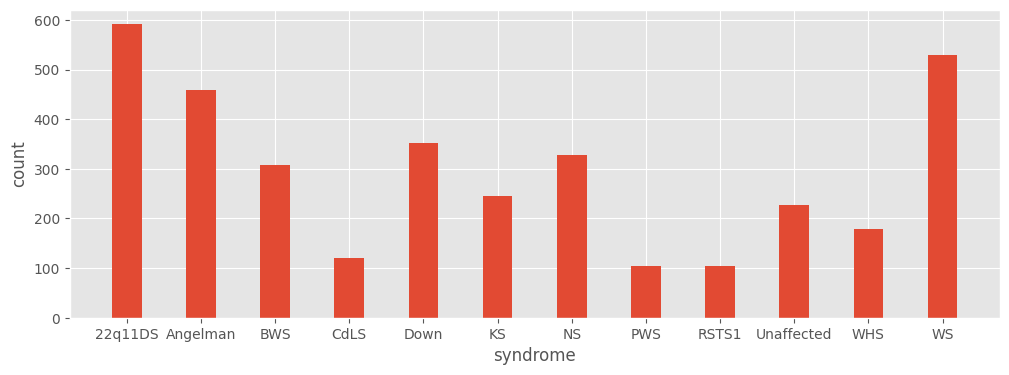

In [40]:
categories = [f.split('Slide')[0] for f in df['image_name']]
labels = np.array([np.argwhere( np.array(sorted(np.unique(categories)))==i ).squeeze() for i in categories])
categories = np.array(categories)

plt.figure(figsize=(12, 4))
plt.bar(sorted(np.unique(categories)), [np.sum(categories==i) for i in sorted(np.unique(categories))], width=0.4)
plt.ylabel('count')
plt.xlabel('syndrome')

plt.savefig('fig-syndrome-distrobution-hist.svg', bbox_inches="tight", pad_inches=0)

In [41]:
import torch
import torchvision

for category in sorted(list(np.unique(categories))):
    
    indices = np.argwhere( categories==category ).squeeze()
    images = []

    for index in indices:    
        image_path = pathlib.Path(data_root, 'images', df.iloc[index]['image_name'])
        img = cv2.imread(image_path.as_posix())
        landmark = df.iloc[index, 5:-1].to_numpy().astype(np.float32).reshape(5, 2)
        warped, M = norm_crop2(img, landmark, image_size=112, mode='arcface')

        sample = 180*np.ones(shape=(128, 128, 3), dtype=np.uint8)
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
        sample[14:14+112, 8:8+112, :] = warped
        sample = cv2.putText(sample, image_path.stem, (8, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.LINE_AA)

        images.append(np.transpose(sample, (2,0,1)))
        #plt.grid(visible=False)
        #plt.imshow(sample, interpolation='lanczos')
        #plt.show()

    images = np.array(images)
    images = np.concatenate((images,
                             255*np.ones(shape=(100-(len(indices)%100), 3, 128, 128), dtype=np.uint8)), axis=0)

    n = 1
    for index in range(0, images.shape[0], 100):
        imgvis = torchvision.utils.make_grid(torch.from_numpy(images[index:index+100,:,:,:]), nrow=10, padding=2, normalize=False)
        imgvis = cv2.cvtColor(np.transpose(imgvis.numpy(), (1,2,0)), cv2.COLOR_BGR2RGB)

        cv2.imwrite(pathlib.Path(pathlib.Path.cwd(), 'metadata', 'patches', '%s-%d %03d-%03d.png'%(category, n, index, index+100)).as_posix(), imgvis)
        n += 1

        #plt.figure(figsize=(15,15))
        #plt.grid(visible=False)
        #plt.imshow(np.transpose(imgvis, (1,2,0)))